## Importation des librairies

In [ ]:
import pulp
import random
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import deque
import pandas as pd
import time
import copy

## Formulation formelle du problème
Le **problème à résoudre** est une version plus complexe du célèbre **problème du voyageur de commerce (TSP)**.
###  Problème du voyageur de commerce (TSP)

Dans le **TSP**, un vendeur doit visiter un certain nombre de villes **une seule fois chacune**, puis **revenir à son point de départ**, en minimisant la **distance totale parcourue**.


###  Problème de tournées de véhicules (VRP)

Le **VRP** (*Vehicle Routing Problem*) est une **généralisation** du TSP.  
Cette fois, il ne s'agit pas d'un seul vendeur, mais de **plusieurs véhicules** qui doivent :

- partir d’un **dépôt central**,
- visiter un ensemble de **clients** pour effectuer des livraisons ou des ramassages,
- puis **revenir au dépôt**.

L’objectif est d’organiser les **tournées de tous les véhicules** pour :

- **desservir tous les clients**,  
- **minimiser les coûts** (distance, temps, coûts...).

## Données du problème
### Représentation du graphe

Le système est modélisé par un **graphe orienté et pondéré** : $ G = (V, E) $

avec :
- $ V = \{v_0, v_1, \dots, v_n\} $   Ensemble des **sommets**, représentant les villes ou les points à visiter.

- $ E \subseteq V \times V $  Ensemble des **arêtes**, représentant les routes entre les villes.

- Chaque arête $ (v_i, v_j) \in E $ est associée à trois **attributs** : la **distance** $ d_{ij} \in \mathbb{R}^{+} $, le **coût monétaire** $ c_{ij} \in \mathbb{R}^{+} $ et le **temps de trajet** $ t_{ij} \in \mathbb{R}^{+} $.


- Un dépôt $ v_0 $ (point de départ et d’arrivée des tournées)

- Un ensemble de $ k $ véhicules, chacun ayant une tournée qui commence et se termine à $ v_0 $



### Objectif

Trouver un ensemble de $ k $ tournées (une par véhicule) telles que :

- Chaque client est visité une seule fois par un seul véhicule
- Le coût total des tournées est **minimisé** (ex. : distance, temps et coût total)
- Utilisation de moins de camion possible


### Contraintes

Nous avons choisi d’intégrer deux contraintes supplémentaires au problème de base :

1. **Utilisation de plusieurs véhicules** : chaque véhicule part du dépôt, visite des clients, puis revient au dépôt.
2. **Coût ou restriction de passage sur certaines arêtes** : certaines routes peuvent avoir un coût plus élevé (par exemple, travaux ou routes bloquées)

## Réduction polynomiale VRP vers TSP:
Le but de cette partie est de montrer que le VRP peut être réduit en temps polynomiale.
- Le TSP consiste à trouver une tournée unique qui passe par tous les sommets une seule fois. 
- Le VRP consiste à trouver k tournées, chacune partant et revenant au dépôt $ v_0 $ , desservant tous les clients

## Représentation graphique du VRP

Nous avons commencé à modéliser notre problème VRP. Pour cela, on a utiliser un code python afin de pouvoir afficher nos graphes sans le respect des contraintes qui sera fait durant le projet

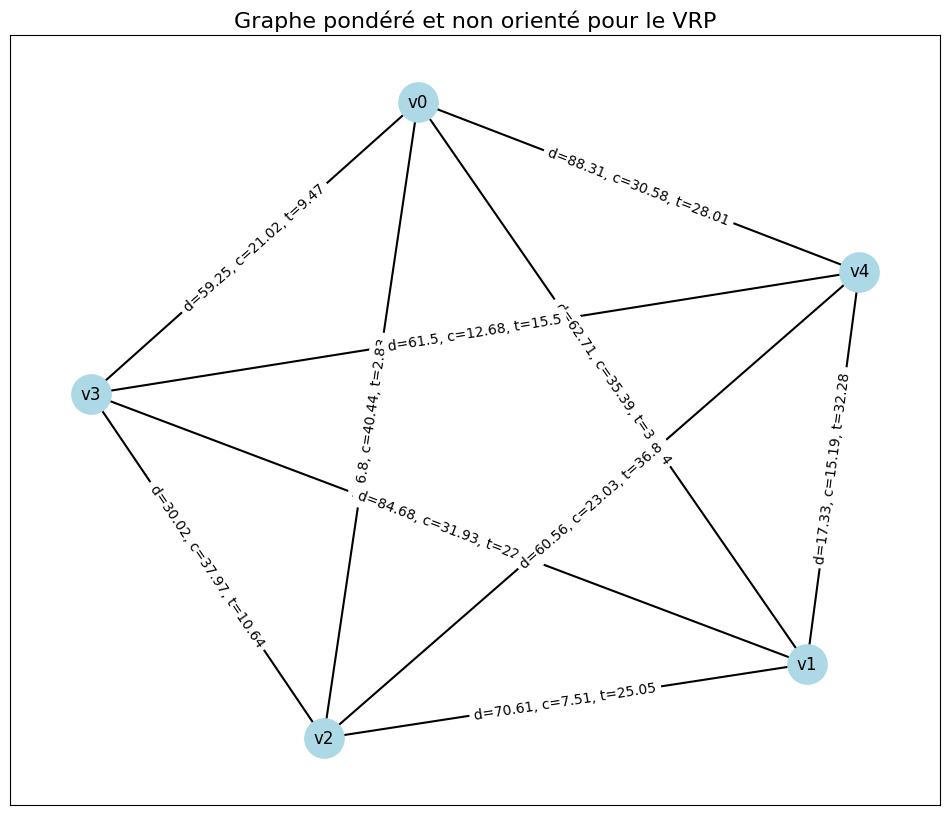

In [5]:
num_clients = 4 
depot = 0
nodes = [depot] + [i for i in range(1, num_clients + 1)]
G = nx.Graph()
for node in nodes:
    G.add_node(node)

for i in nodes:
    for j in nodes:
        if i < j:  
            distance = round(random.uniform(1, 100), 2)  
            cost = round(random.uniform(1, 50), 2)       
            time = round(random.uniform(1, 60), 2)     
            G.add_edge(i, j, distance=distance, cost=cost, time=time)

mapping = {node: f"v{node}" for node in G.nodes}
G = nx.relabel_nodes(G, mapping)
pos = nx.spring_layout(G, seed=42)  
plt.figure(figsize=(12, 10)) 
nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue')
nx.draw_networkx_edges(G, pos, width=1.5)
nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')
edge_labels = {
    (u, v): f"d={data['distance']}, c={data['cost']}, t={data['time']}"
    for u, v, data in G.edges(data=True)
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
plt.title("Graphe pondéré et non orienté pour le VRP", fontsize=16)
plt.show()


### Transformation du VRP en TSP

Pour transformer le VRP en TSP, **on crée 𝑘 copies du dépôt dans le graphe**. Ces copies représentent **les 𝑘 tournées distinctes du VRP**. En attribuant des coûts très élevés entre ces copies, on empêche le TSP de relier plusieurs dépôts dans une même boucle. Chaque copie devient ainsi le départ et l’arrivée d’une tournée spécifique, simulant l’utilisation de 𝑘 véhicules dans le TSP.
Plusieurs contraintes sont respectés pour les poids des aretes
- Les distances entre les clients sont conservées
- Les distances entre les copies du dépôt sont fixées à **une grande valeur 𝑀** pour décourager le passage direct entre ces copies
-Les distances entre chaque copie du dépôt $v_0^{(i)}$ et les clients sont égales à celles du dépôt original $v_0$ dans l’instance VRP.


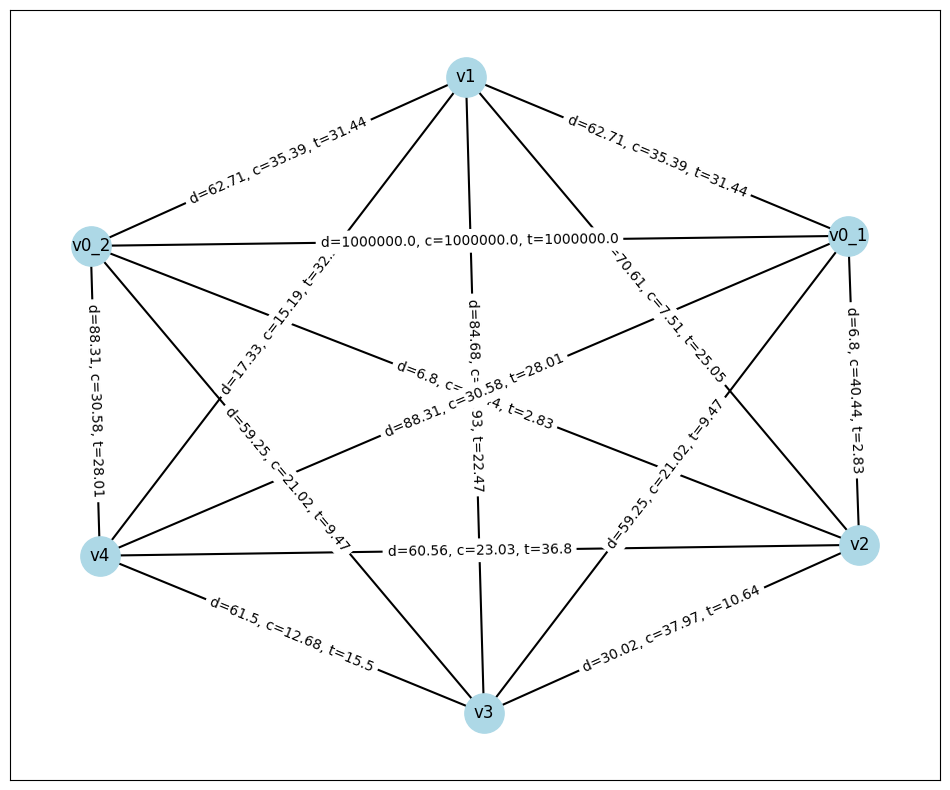

In [6]:
nombre_camion = 2
for i in range(1, nombre_camion + 1):
    depot_copy = f"v0_{i}"
    G.add_node(depot_copy)
    for node in G.nodes:
        if node != depot_copy and not node.startswith("v0_"):  
            original_edge = G.get_edge_data("v0", node)
            if original_edge:
                G.add_edge(depot_copy, node, **original_edge)

for i in range(1, nombre_camion + 1):
    for j in range(i + 1, nombre_camion + 1):
        G.add_edge(f"v0_{i}", f"v0_{j}", distance=1e6, cost=1e6, time=1e6)

if G.has_node("v0"):
    G.remove_node("v0")

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue')
nx.draw_networkx_edges(G, pos, width=1.5)
nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')
edge_labels = {
    (u, v): f"d={data['distance']}, c={data['cost']}, t={data['time']}"
    for u, v, data in G.edges(data=True)
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
plt.show()

###  Conclusion sur la complexité du VRP

Le **Vehicle Routing Problem (VRP)** est une **généralisation** du **problème du voyageur de commerce (TSP)**.

Nous avons montré qu’une instance de VRP peut être transformée en une instance **équivalente de TSP en temps polynomial**, notamment en **dupliquant le dépôt** et en **modifiant les coûts** du graphe.

Or, le **TSP est un problème NP-complet**, ce qui signifie qu’il **n’existe pas d’algorithme polynomial connu** permettant de le résoudre efficacement dans tous les cas.

Cette réduction polynomiale montre donc que le VRP est lui aussi **NP-complet**, car **il est au moins aussi complexe que le TSP**.


### Génération des instances aléatoires

In [7]:
def generate_weight(restricted_edge, distance_range, time_range):
    if random.random() < restricted_edge: distance = 999
    else: distance = random.randint(*distance_range)
    if random.random() < restricted_edge: time = 999
    else: time = random.randint(*time_range)
    return distance, time

def generate_graph(n, restricted_edge=0.1, distance_range=(1, 100), time_range=(1, 60)):
    G = nx.complete_graph(n)
    for u, v in G.edges():
        distance, time = generate_weight(restricted_edge, distance_range, time_range)
        G[u][v]['distance'] = distance
        G[u][v]['time'] = time
    return G

In [8]:
def draw_graph(G, routes=None, depot=0, title="Graphe complet généré aléatoirement"):
    pos = nx.spring_layout(G, seed=42)
    # edge_labels = {(u, v): f"D:{G.edges[u, v]['distance']}, T:{G.edges[u, v]['time']}" for u, v in G.edges}
    edge_labels = {(u, v): G.edges[u, v]['distance'] for u, v in G.edges}

    plt.figure(figsize=(8, 5))
    plt.title(title)
    nx.draw_networkx_nodes(G, pos, node_color=['lightgreen' if n == depot else 'lightblue' for n in G.nodes], node_size=250)
    nx.draw_networkx_labels(G, pos, font_size=7)
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    if routes:
        line_color = ["red", "blue", "green", "orange", "purple"]
        for k, edges in enumerate(routes):
            nx.draw_networkx_edges(G, pos, edgelist=edges, width=1.5, edge_color=line_color[k % len(line_color)])
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)
    plt.show()

In [9]:
seed = random.randint(0, 100000)
random.seed(seed)
print(f"Seed : {seed}")

Seed : 35531


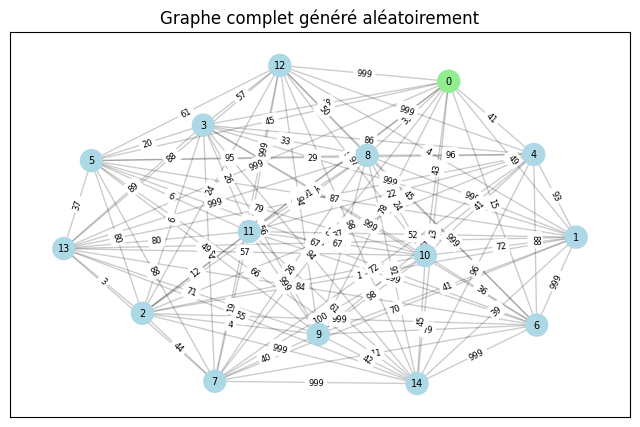

In [10]:
N = 15
G = generate_graph(N)
draw_graph(G)

# Modélisation linéaire du problème de tournées de véhicules pour minimiser la distance (VRP)

Ce modèle linéaire permet de résoudre un problème de tournées de véhicules, où plusieurs camions partent d’un dépôt, visitent des clients, puis reviennent au dépôt.  
L’objectif est de **minimiser la distance totale parcourue** tout en respectant certaines contraintes.


##  Données du problème

Le système est modélisé par un **graphe orienté pondéré** $G = (V, E)$ :

- $V = \{v_0, v_1, ..., v_n\}$ : ensemble des sommets, représentant les clients à visiter.  
- $v_0$ désigne le **dépôt** (point de départ et d’arrivée).
- $E \subseteq V \times V$ : ensemble des arêtes dirigées (routes).
- Chaque arête $(i, j) \in E$ est associée à une **distance** $d_{ij} \in \mathbb{R}^+$.
- $k$ : nombre de véhicules disponibles.


##  Variables de décision

- $x_{ij} \in \{0, 1\}$ : 1 si l’arête $(i, j)$ est empruntée par un véhicule, 0 sinon.

- $u_i \in \mathbb{Z}$ : variable auxiliaire pour éliminer les sous-tours (formulation MTZ), définie pour tous les $i \in \{1, ..., n\}$.



##  Fonction objectif

Minimiser la **distance totale parcourue** :

$$
\min \sum_{(i,j) \in E} d_{ij} \cdot x_{ij}
$$


##  Contraintes

### 1. Visite unique de chaque client

Chaque client doit être visité **exactement une fois** :

$$
\sum_{i \in V,\, i \ne j} x_{ij} = 1 \quad \forall j \in V 
$$

$$
\sum_{j \in V,\, j \ne i} x_{ij} = 1 \quad \forall i \in V 
$$


### 2. Utilisation du dépôt

Le dépôt $v_0$ est utilisé par exactement $k$ véhicules :

$$
\sum_{j \in V } x_{0j} = k
$$

$$
\sum_{i \in V} x_{i0} = k
$$



### 3. Élimination des sous-tours (MTZ)

Pour éviter la création de cycles ne passant pas par le dépôt :

$
1 \le u_i \le n \quad \forall i \in V 
$
$
u_i - u_j + n \cdot x_{ij} \le n - 1 \quad \forall i \ne j,\ i,j \in V
$

##  Interprétation

Ce modèle permet de :

- Planifier les tournées de $k$ véhicules partant et revenant au dépôt $v_0$
- Assurer la visite unique de chaque client
- Éviter les cycles internes sans passer par le dépôt
- **Minimiser la distance totale** pour un impact économique et écologique réduit

In [11]:
def solve_distance_vrp(G, K, depot=0):
    customers = [v for v in G.nodes if v != depot]      # Sommets à visiter
    m = len(customers)                                  # Nombre de clients
    L = m // K                                          # Nombre minimum de clients par camion
    U = L if m % K == 0 else L + 1                      # Nombre maximum de clients par camion

    arcs = [(i, j) for i in G.nodes for j in G.nodes if i != j]

    # --- Définir le problème --- #
    prob = pulp.LpProblem("Distance_VRP", pulp.LpMinimize)

    # --- Variables de décision --- #
    # x[i,j,k] = 1 si le camion k prend l'arc (i,j), 0 sinon
    # u[i,k] = Nombre de clients visités par le camion k avant le client i
    x = pulp.LpVariable.dicts("x", ((i, j, k) for (i, j) in arcs for k in range(K)), lowBound=0, upBound=1, cat="Binary")
    u = pulp.LpVariable.dicts("u", ((i, k) for i in customers for k in range(K)), lowBound=1, upBound=m, cat="Integer")

    # --- Fonction objectif : minimiser la distance totale parcourue --- #
    prob += pulp.lpSum(G.edges[i, j]["distance"] * x[(i, j, k)] for (i, j) in arcs for k in range(K))

    # --- Contraintes --- #
    # Chaque client exactement une fois
    for i in customers:
        prob += pulp.lpSum(x[(i, j, k)] for j in G.nodes if j != i for k in range(K)) == 1

    # Un départ & un retour dépôt par camion
    for k in range(K):
        prob += pulp.lpSum(x[(0, j, k)] for j in customers) == 1
        prob += pulp.lpSum(x[(i, 0, k)] for i in customers) == 1

    # Conservation du flux
    for k in range(K):
        for v in customers:
            prob += (pulp.lpSum(x[(i, v, k)] for i in G.nodes if i != v) - pulp.lpSum(x[(v, j, k)] for j in G.nodes if j != v)) == 0

    # MTZ : élimination des sous-tours
    for k in range(K):
        for i, j in itertools.permutations(customers, 2):
            prob += u[(i, k)] - u[(j, k)] + m * x[(i, j, k)] <= m - 1

    # Équilibrage (même nombre de clients ±1 par camion)
    # L = m // K, U = L + 1 si m % K != 0
    # L <= nombre de clients par camion <= U
    for k in range(K):
        prob += pulp.lpSum(x[(i, j, k)] for i in customers for j in G.nodes if j != i) >= L
        prob += pulp.lpSum(x[(i, j, k)] for i in customers for j in G.nodes if j != i) <= U

    # Résolution
    prob.solve(pulp.PULP_CBC_CMD(msg=False))

    # Récupération des arêtes sélectionnées pour chaque camion
    routes = [[] for _ in range(K)]
    for k in range(K):
        for i, j in arcs:
            if pulp.value(x[(i, j, k)]) > 0.5:
                routes[k].append((i, j))

    return routes, pulp.value(prob.objective)


RÉSUMÉ GLOBAL
Distance totale : 353
Temps total     : 2528

Camion      Distance     Temps   Tournée
--------------------------------------
0                151      1321   0 → 10 → 8 → 9 → 2 → 13 → 7 → 6 → 0
1                202      1207   0 → 14 → 1 → 12 → 3 → 5 → 11 → 4 → 0


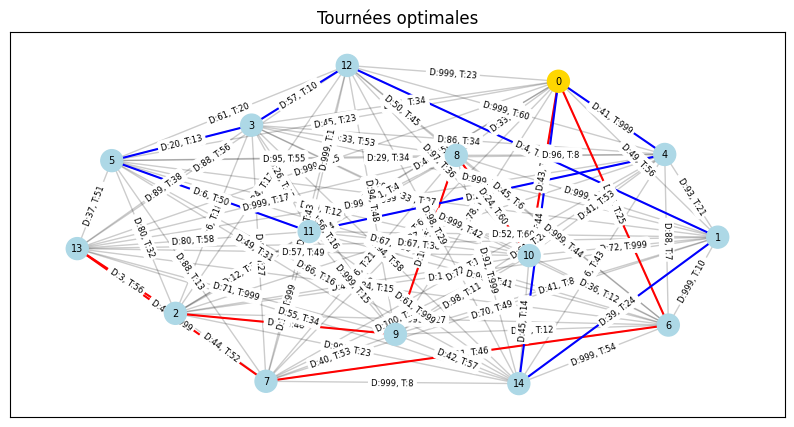

In [12]:
def print_solution_summary(G, routes, depot=0):
    total_distance = sum(G.edges[u, v]['distance'] for edges in routes for u, v in edges)
    total_time = sum(G.edges[u, v]['time'] for edges in routes for u, v in edges)

    print("\n\033[1mRÉSUMÉ GLOBAL\033[0m")
    print(f"Distance totale : {total_distance}")
    print(f"Temps total     : {total_time}")

    # En-tête du tableau
    header = f"\n\033[1m{'Camion':<8}{'Distance':>12}{'Temps':>10}   Tournée\033[0m"
    print(header)
    print("-" * (len(header) - 11))

    # Détail par camion
    for k, edges in enumerate(routes):
        dist = sum(G.edges[u, v]['distance'] for u, v in edges)
        t = sum(G.edges[u, v]['time'] for u, v in edges)

        # --- tentative de reconstruction du chemin dans l'ordre ---
        path = [depot]
        remaining = edges.copy()
        while remaining:
            for idx, (i, j) in enumerate(remaining):
                if i == path[-1]:
                    path.append(j)
                    remaining.pop(idx)
                    break
                elif j == path[-1]:
                    path.append(i)
                    remaining.pop(idx)
                    break
            else:
                # si l'ordre exact n'est pas déductible, on sort
                path.extend([edge for pair in remaining for edge in pair])
                break
        path_str = " → ".join(map(str, path))
        print(f"{k:<8}{dist:>12}{t:>10}   {path_str}")

def draw_solution(G, routes, depot=0, title="Tournées optimales"):
    pos = nx.spring_layout(G, seed=42)
    edge_labels = {(u, v): f"D:{G.edges[u, v]['distance']}, T:{G.edges[u, v]['time']}" for u, v in G.edges}

    plt.figure(figsize=(10, 5))
    plt.title(title)
    nx.draw_networkx_nodes(G, pos, node_color=['gold' if n == depot else 'lightblue' for n in G.nodes], node_size=250)
    nx.draw_networkx_labels(G, pos, font_size=7)
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    line_color = ["red", "blue", "green", "orange", "purple"]
    for k, edges in enumerate(routes):
        nx.draw_networkx_edges(G, pos, edgelist=edges, width=1.5, edge_color=line_color[k % len(line_color)])
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)
    plt.show()

routes, total_distance = solve_distance_vrp(G, 2)
print_solution_summary(G, routes)
draw_solution(G, routes, title="Tournées optimales")


### Méta heuristique
Nous avons fait le choix d'utiliser deux méta heuristiques pour résoudre notre problème de tournées de véhicules. Ces deux algorithmes sont les suivants :
- **la colonie de fourmis** : qui s'inspire du comportement des fourmis pour trouver le chemin le plus court entre le dépôt et les clients.
- **la recherche tabou** : qui utilise une mémoire pour éviter de revisiter les solutions déjà explorées, permettant ainsi d'explorer efficacement l'espace de recherche.

In [13]:
def plot_vrp_solution(graph, routes, depot):
    #dessiner le graphe
    pos = nx.spring_layout(graph, seed=42)  
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray'] 
    plt.figure(figsize=(12, 10))
    nx.draw_networkx_nodes(graph, pos, node_size=800, node_color='lightblue')
    nx.draw_networkx_labels(graph, pos, font_size=12, font_color='black')
    
    #dessiner les arêtes
    for i, route in enumerate(routes):
        color = colors[i % len(colors)]  
        edges = [(route[j], route[j + 1]) for j in range(len(route) - 1)]
        nx.draw_networkx_edges(graph, pos, edgelist=edges, width=2.5, edge_color=color, label=f'Camion {i + 1}')
    nx.draw_networkx_nodes(graph, pos, nodelist=[depot], node_size=1000, node_color='yellow', label='Dépôt')
    plt.title("Solution VRP avec routes colorées", fontsize=16)
    plt.legend()
    plt.show()

In [14]:
def ant_colony_vrp_fast(graph, depot, num_vehicles=2, num_ants=10, num_iterations=50, alpha=1, beta=2, evaporation_rate=0.5, pheromone_init=1.0):
    pheromones = {edge: pheromone_init for edge in graph.edges}
    best_routes = None
    best_cost = float('inf')
    nodes = list(graph.nodes)
    nodes.remove(depot)
    nodes_per_vehicle = len(nodes) // num_vehicles
    extra_nodes = len(nodes) % num_vehicles

    courantes = []
    meilleures_courantes = []

    for iteration in range(num_iterations):
        for ant in range(num_ants):
            unvisited = set(graph.nodes)
            unvisited.remove(depot)
            routes = []
            total_cost = 0

            for vehicle in range(num_vehicles):
                current_route = [depot]
                current_node = depot
                visited_this_trip = set()
                nodes_to_visit = nodes_per_vehicle + (1 if vehicle < extra_nodes else 0)

                while unvisited and len(visited_this_trip) < nodes_to_visit:
                    neighbors = [n for n in graph.neighbors(current_node) if n in unvisited]
                    if not neighbors:
                        break

                    probabilities = []
                    for neighbor in neighbors:
                        edge = (current_node, neighbor) if (current_node, neighbor) in pheromones else (neighbor, current_node)
                        pheromone = pheromones[edge]
                        distance = graph[current_node][neighbor]['distance']
                        probabilities.append((neighbor, (pheromone ** alpha) * ((1 / distance) ** beta)))

                    if not probabilities:
                        break

                    total_prob = sum(prob[1] for prob in probabilities)
                    next_node = random.choices(
                        [node for node, _ in probabilities],
                        [prob / total_prob for _, prob in probabilities]
                    )[0]

                    current_route.append(next_node)
                    total_cost += graph[current_node][next_node]['distance']
                    unvisited.remove(next_node)
                    visited_this_trip.add(next_node)
                    current_node = next_node

                if current_node != depot:
                    current_route.append(depot)
                    total_cost += graph[current_node][depot]['distance']

                routes.append(current_route)

            if total_cost < best_cost:
                best_cost = total_cost
                best_routes = routes

        # Sauvegarde des coûts à chaque itération
        courantes.append(total_cost)
        meilleures_courantes.append(best_cost)

        # Mise à jour des phéromones
        for edge in pheromones:
            pheromones[edge] *= (1 - evaporation_rate)

        for route in best_routes:
            for i in range(len(route) - 1):
                edge = (route[i], route[i + 1]) if (route[i], route[i + 1]) in pheromones else (route[i + 1], route[i])
                pheromones[edge] += 1 / best_cost

    return best_routes, best_cost, courantes, meilleures_courantes

### Recherche tabou

In [15]:
def smart_initial_solution(graph, nombre_camion, depot):
    nodes = list(graph.nodes())
    nodes.remove(depot)
    
    # Trier les villes par distance au dépôt
    nodes.sort(key=lambda node: graph[depot][node]['distance'] if graph.has_edge(depot, node) else graph[node][depot]['distance'])
    
    split = [len(nodes) // nombre_camion] * nombre_camion
    for i in range(len(nodes) % nombre_camion):
        split[i] += 1
    
    solution = []
    idx = 0
    for s in split:
        route = [depot] + nodes[idx:idx+s] + [depot]
        idx += s
        solution.append(route)
    return solution

def calculate_cost(graph, solution):
    total_cost = 0
    for route in solution:
        for i in range(len(route) - 1):
            u, v = route[i], route[i+1]
            if graph.has_edge(u, v):
                total_cost += graph[u][v]['distance']
            elif graph.has_edge(v, u):
                total_cost += graph[v][u]['distance']
            else:
                total_cost += 9999  # pénalité énorme
    return total_cost

def tabu_search(graph, nombre_camion, depot=0, iterations=500, tabu_tenure=15):
    solution = smart_initial_solution(graph, nombre_camion, depot)
    best_solution = copy.deepcopy(solution)
    best_cost = calculate_cost(graph, best_solution)
    tabu_list = []
    
    # Pour suivre l'évolution des coûts
    courantes = []
    meilleures_courantes = []

    for _ in range(iterations):
        neighborhood = []
        for i in range(nombre_camion):
            for j in range(1, len(solution[i]) - 1):
                for k in range(nombre_camion):
                    if i != k:
                        for l in range(1, len(solution[k]) - 1):
                            neighbor = copy.deepcopy(solution)
                            neighbor[i][j], neighbor[k][l] = neighbor[k][l], neighbor[i][j]
                            if neighbor not in tabu_list:
                                neighborhood.append((neighbor, calculate_cost(graph, neighbor)))
        
        if not neighborhood:
            break
        
        neighborhood.sort(key=lambda x: x[1])
        solution, current_cost = neighborhood[0]

        # Mise à jour de la meilleure solution rencontrée
        if current_cost < best_cost:
            best_solution = copy.deepcopy(solution)
            best_cost = current_cost

        tabu_list.append(solution)
        if len(tabu_list) > tabu_tenure:
            tabu_list.pop(0)

        courantes.append(current_cost)
        meilleures_courantes.append(best_cost)

    return best_solution, best_cost, courantes, meilleures_courantes

## Comparaison des résultats:

### Test sur plusieurs instances pour évaluer la performance des algorithmes

Résulat pour la colonie de fourmi

In [16]:
def run_optimization_algorithm_ant(algorithm, graph, num_vehicles, depot=0, iterations=500, tabu_tenure=15, **kwargs):
    """
    Fonction générique pour exécuter un algorithme d'optimisation comme Tabou ou Fourmis.
    """
    best_solution, best_cost, courantes, meilleures_courantes = algorithm(
        graph, depot=depot, num_vehicles=num_vehicles, num_iterations=iterations, **kwargs
    )

    plt.xlabel("Nombre d'itérations", fontsize=16)
    plt.ylabel("Coût total", fontsize=16)
    plt.plot(range(len(courantes)), courantes, label="Coût courant", color='blue')
    plt.plot(range(len(meilleures_courantes)), meilleures_courantes, label="Meilleur coût global", color='red')
    plt.legend()
    plt.title(f"Évolution des coûts pour l'algorithme {algorithm.__name__}")
    plt.show()

    return best_solution, best_cost, courantes, meilleures_courantes

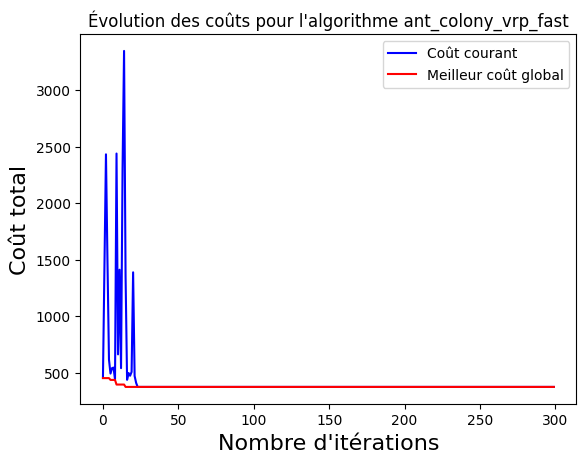

In [17]:
best_routes, best_cost, courantes, meilleures_courantes = run_optimization_algorithm_ant(
    ant_colony_vrp_fast,
    G,
    num_vehicles=2,
    depot=0,
    iterations=300,         # num_iterations pour colonie de fourmis
    num_ants=20,            # paramètres supplémentaires via **kwargs
    alpha=1.5,
    beta=2,
    evaporation_rate=0.3
)

Résultat pour la recherche tabou :

In [18]:
def run_optimization_algorithm_tabou(algorithm, graph, num_vehicles, depot=0, iterations=500, tabu_tenure=15):
    """
    Fonction générique pour exécuter un algorithme d'optimisation comme la recherche Tabou ou la colonie de fourmis.
    
    Args:
    - algorithm: fonction représentant l'algorithme à utiliser (par exemple `tabu_search` ou `ant_colony_optimization`).
    - graph: le graphe sur lequel l'optimisation doit être effectuée.
    - num_vehicles: nombre de véhicules.
    - depot: index du dépôt.
    - iterations: nombre d'itérations.
    - tabu_tenure: tenure de la liste Tabou (utile pour la recherche Tabou).
    
    Returns:
    - best_solution: la meilleure solution trouvée.
    - best_cost: le coût de la meilleure solution.
    - courantes: la liste des coûts à chaque itération.
    - meilleures_courantes: la liste des meilleurs coûts globaux à chaque itération.
    """
    best_solution, best_cost, courantes, meilleures_courantes = algorithm(graph, num_vehicles, depot, iterations, tabu_tenure)

    # Tracer l'évolution des coûts
    plt.xlabel("Nombre d'itérations", fontsize=16)
    plt.ylabel("Coût total", fontsize=16)
    plt.plot(range(len(courantes)), courantes, label="Coût courant", color='blue')
    plt.plot(range(len(meilleures_courantes)), meilleures_courantes, label="Meilleur coût global", color='red')
    plt.legend()
    plt.title(f"Évolution des coûts pour l'algorithme {algorithm.__name__}")
    plt.show()

    return best_solution, best_cost, courantes, meilleures_courantes

In [23]:
iterations = 300  # Nombre d'itérations
tabu_tenure = 20  # Tenure de la liste Tabou
seed = 42  # Pour la reproductibilité
best_solution, best_cost, courantes, meilleures_courantes = run_optimization_algorithm_tabou(tabu_search, G, nombre_camion, depot=0, iterations=iterations, tabu_tenure=tabu_tenure)

print("Solution trouvée :")
for idx, route in enumerate(best_solution):
    print(f" Véhicule {idx+1} : {route}")
print("Coût total :", best_cost)

plot_vrp_solution(G, routes, depot=0)

NameError: name 'copy' is not defined

In [22]:
def run_iteration_experiment_with_pl(existing_graph, num_vehicles=2, iteration_values=[10, 20, 30, 40, 50, 60]):
    """
    Teste les performances des algorithmes PL, Tabou et Fourmis sur un graphe existant.
    """
    results = {
        'iterations': [],
        'method': [],
        'cost': [],
        'time': []
    }

    for iterations in iteration_values:
        # Utilisation du graphe existant
        G_test = existing_graph

        # === Programmation Linéaire (PL) ===
        try:
            start_time = time.time()
            routes_pl, cost_pl = solve_distance_vrp(G_test, num_vehicles, depot=0)
            time_pl = time.time() - start_time
        except:
            routes_pl, cost_pl, time_pl = None, None, None

        if cost_pl is not None:
            results['iterations'].append(iterations)
            results['method'].append('PL')
            results['cost'].append(cost_pl)
            results['time'].append(time_pl)

        # === Recherche Tabou ===
        start_time = time.time()
        best_tabu_solution, best_tabu_cost, _, _ = tabu_search(
            G_test, num_vehicles, depot=0, iterations=iterations, tabu_tenure=15
        )
        time_tabu = time.time() - start_time

        results['iterations'].append(iterations)
        results['method'].append('Tabou')
        results['cost'].append(best_tabu_cost)
        results['time'].append(time_tabu)

        # === Colonie de Fourmis ===
        start_time = time.time()
        best_aco_routes, best_aco_cost, _, _ = ant_colony_vrp_fast(
            G_test, depot=0, num_vehicles=num_vehicles, num_ants=10, num_iterations=iterations
        )
        time_aco = time.time() - start_time

        results['iterations'].append(iterations)
        results['method'].append('Fourmis')
        results['cost'].append(best_aco_cost)
        results['time'].append(time_aco)

    # Organisation des résultats dans un DataFrame
    df_results = pd.DataFrame(results)

    # Calcul des moyennes et écarts-types
    summary = df_results.groupby(['iterations', 'method']).agg(
        mean_cost=('cost', 'mean'),
        std_cost=('cost', 'std'),
        mean_time=('time', 'mean'),
        std_time=('time', 'std')
    ).reset_index()

    # --- Graphique 1 : Coût moyen ---
    plt.figure(figsize=(10, 6))
    for method in ['Tabou', 'Fourmis', 'PL']:
        if method in summary['method'].values:
            data = summary[summary['method'] == method]
            plt.errorbar(data['iterations'], data['mean_cost'], yerr=data['std_cost'], label=method, capsize=5)
    plt.xlabel('Nombre d\'itérations')
    plt.ylabel('Coût moyen')
    plt.title('Comparaison des coûts moyens')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Graphique 2 : Temps moyen ---
    plt.figure(figsize=(10, 6))
    for method in ['Tabou', 'Fourmis', 'PL']:
        if method in summary['method'].values:
            data = summary[summary['method'] == method]
            plt.errorbar(data['iterations'], data['mean_time'], yerr=data['std_time'], label=method, capsize=5)
    plt.xlabel('Nombre d\'itérations')
    plt.ylabel('Temps moyen (s)')
    plt.title('Comparaison des temps moyens')
    plt.legend()
    plt.grid(True)
    plt.show()

run_iteration_experiment_with_pl(G, num_vehicles=2, iteration_values=[10, 20, 30, 40, 50, 60])

AttributeError: 'float' object has no attribute 'time'

### Références utiles

- https://fr.wikipedia.org/wiki/Probl%C3%A8me_du_voyageur_de_commerce
- https://fr.wikipedia.org/wiki/Probl%C3%A8me_de_tourn%C3%A9es_de_v%C3%A9hicules
- Workshop
- https://networkx.org/documentation/stable/reference/introduction.html
- https://www.guru99.com/fr/travelling-salesman-problem.html#:~:text=Le%20probl%C3%A8me%20du%20voyageur%20de%20commerce%20%28TSP%29%20est,fa%C3%A7on%20exponentielle%20avec%20l%E2%80%99augmentation%20du%20nombre%20de%20villes.
- https://github.com/jwang0306/vehicle-routing-problem?tab=readme-ov-file
- https://www.youtube.com/watch?v=GiDsjIBOVoA&list=TLPQMjcwNDIwMjWGmE-QXy8F6w&index=1&pp=gAQBiAQB